In [1]:
import sys
!{sys.executable} -m pip install numpy pandas scikit-learn xgboost statsmodels matplotlib tensorflow

In [2]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy scikit-learn pywavelets tensorflow autokeras

2025-07-15 13:53:02,656 [INFO] Loaded data with 86 records.
2025-07-15 13:53:02,819 [INFO] Train samples: 62 | Test samples: 21
2025-07-15 13:53:02,824 [INFO] Starting bootstrapping (50 runs)...
2025-07-15 13:53:02,825 [INFO] Bootstrapping model: GB
2025-07-15 13:53:06,887 [INFO] Bootstrapping model: XGBoost



—GB Regression—
 R²: -0.139
 RMSE: 1.546
 MAE: 1.074
 Skill Score: -6.71%

—GB Binary (<714.58 ft)—
 Confusion Matrix: TN=7, FP=0, FN=3, TP=11
 Accuracy: 0.857
 Precision: 1.000
 Recall: 0.786
 F1 Score: 0.880
 POD: 0.786, POFD: 0.000, Bias: 0.786, PSS: 0.786

—GB Uncertainty—
 Mean Std Dev: 0.797
 Mean Prediction Interval Width: 2.833
 Prediction Interval Coverage Probability (PICP): 0.619


2025-07-15 13:53:09,138 [INFO] Bootstrapping model: SVR
2025-07-15 13:53:09,245 [INFO] Generating time series plot with uncertainty bands...



—XGBoost Regression—
 R²: 0.156
 RMSE: 1.331
 MAE: 0.954
 Skill Score: 8.15%

—XGBoost Binary (<714.58 ft)—
 Confusion Matrix: TN=7, FP=0, FN=2, TP=12
 Accuracy: 0.905
 Precision: 1.000
 Recall: 0.857
 F1 Score: 0.923
 POD: 0.857, POFD: 0.000, Bias: 0.857, PSS: 0.857

—XGBoost Uncertainty—
 Mean Std Dev: 0.981
 Mean Prediction Interval Width: 3.448
 Prediction Interval Coverage Probability (PICP): 0.714

—SVR Regression—
 R²: -0.760
 RMSE: 1.922
 MAE: 1.639
 Skill Score: -32.66%

—SVR Binary (<714.58 ft)—
 Confusion Matrix: TN=7, FP=0, FN=5, TP=9
 Accuracy: 0.762
 Precision: 1.000
 Recall: 0.643
 F1 Score: 0.783
 POD: 0.643, POFD: 0.000, Bias: 0.643, PSS: 0.643

—SVR Uncertainty—
 Mean Std Dev: 0.470
 Mean Prediction Interval Width: 1.751
 Prediction Interval Coverage Probability (PICP): 0.190


2025-07-15 13:53:10,062 [INFO] Time-series plot saved to: C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\ML_PLOTS\TimeSeries_GWL_Uncertainty_MG6.png


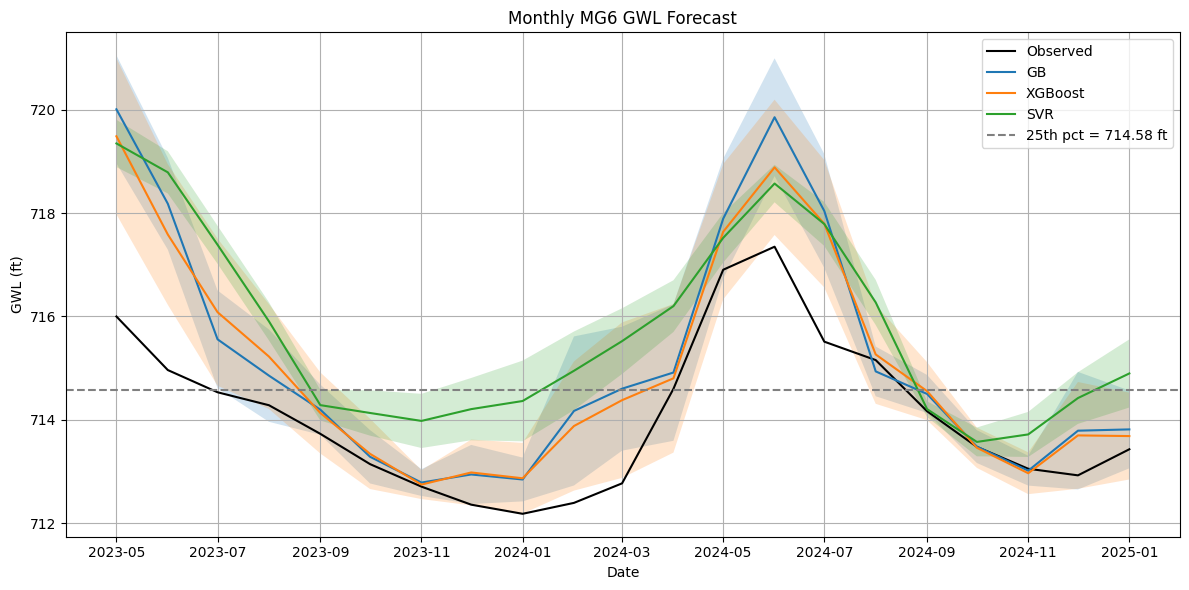

In [4]:
import sys
import os
import types
import logging
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score
)

# Logging Setup 
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.INFO
)
logger = logging.getLogger(__name__)

# Input and output paths
INPUT_CSV = r"C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\MG6_plus_MG4_1month_3month_time_engineered.csv"
PLOTS_DIR = Path(r"C:\Users\cbeaulieu\Downloads\Machine_Learning_GWL\ML_PLOTS")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# ML hyperparamters
WINDOW = 3 # use previous three month to infrom next months prediction
TRAIN_RATIO = 0.75 # split data in a 75% train 25% test datasets
N_BOOT = 50 # Boostrapping, generates 50 predictions for one input.


# Load Data
df = (
    pd.read_csv(INPUT_CSV, parse_dates=['date'])
      .set_index('date')
      .sort_index()
      .dropna()
)
logger.info("Loaded data with %d records.", len(df))

#Inputs to ML model to forecast the target variable
FEATURES = ['PRCP_monthly', 'discharge_cfs_monthly', 'gw_elev_mg4_monthly']
TARGET = 'gw_elev_mg6_monthly'

Xw, y = [], []
for i in range(WINDOW, len(df)):
    Xw.append(df[FEATURES].iloc[i-WINDOW:i].values)
    y.append(df[TARGET].iloc[i])
X = np.array(Xw)
y = np.array(y)

n_samples, _, n_feats = X.shape
n_train = int(n_samples * TRAIN_RATIO)
logger.info("Train samples: %d | Test samples: %d", n_train, n_samples - n_train)

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]
dates_test = df.index[-len(y_test):]

THRESHOLD = np.percentile(y_train, 25) # defines threshold for binary forecast

Xtr = X_train.reshape((n_train, -1))
Xte = X_test.reshape((n_samples - n_train, -1))
scaler = MinMaxScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xte_s = scaler.transform(Xte)

# Evaluation Functions
def skill_score(y_t, y_p):
    rm = np.sqrt(mean_squared_error(y_t, y_p))
    rb = np.sqrt(np.mean((y_t - y_t.mean())**2))
    return 100 * (1 - rm/rb)

def eval_reg(y_t, y_p, name):
    r2   = r2_score(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    mae  = mean_absolute_error(y_t, y_p)
    ss   = skill_score(y_t, y_p)
    print(f"\n—{name} Regression—")
    print(f" R²: {r2:.3f}")
    print(f" RMSE: {rmse:.3f}")
    print(f" MAE: {mae:.3f}")
    print(f" Skill Score: {ss:.2f}%")

def eval_bin(y_t, y_p, name):
    yt = (y_t < THRESHOLD).astype(int)
    yp = (y_p < THRESHOLD).astype(int)

    labels = [0, 1]
    cm = confusion_matrix(yt, yp, labels=labels)

    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        
        TN = FP = FN = TP = 0
        if yt[0] == 0:
            TN = cm[0, 0]
        else:
            TP = cm[0, 0]

    acc  = accuracy_score(yt, yp)
    prec = precision_score(yt, yp, zero_division=0)
    rec  = recall_score(yt, yp, zero_division=0)
    f1   = f1_score(yt, yp, zero_division=0)
    POD  = TP / (TP + FN) if TP + FN > 0 else 0
    POFD = FP / (FP + TN) if FP + TN > 0 else 0
    bias = (TP + FP) / (TP + FN) if TP + FN > 0 else np.nan
    pss  = (TP * TN - FP * FN) / ((TP + FN) * (FP + TN)) if (TP + FN) * (FP + TN) > 0 else np.nan

    print(f"\n—{name} Binary (<{THRESHOLD:.2f} ft)—")
    print(f" Confusion Matrix: TN={TN}, FP={FP}, FN={FN}, TP={TP}")
    print(f" Accuracy: {acc:.3f}")
    print(f" Precision: {prec:.3f}")
    print(f" Recall: {rec:.3f}")
    print(f" F1 Score: {f1:.3f}")
    print(f" POD: {POD:.3f}, POFD: {POFD:.3f}, Bias: {bias:.3f}, PSS: {pss:.3f}")

def uncertainty_metrics(predictions, y_true, name):
    lower = np.percentile(predictions, 2.5, axis=0)
    upper = np.percentile(predictions, 97.5, axis=0)
    width = upper - lower
    mean_width = width.mean()
    in_interval = ((y_true >= lower) & (y_true <= upper)).mean()
    std_dev = predictions.std(axis=0).mean()
    print(f"\n—{name} Uncertainty—")
    print(f" Mean Std Dev: {std_dev:.3f}")
    print(f" Mean Prediction Interval Width: {mean_width:.3f}")
    print(f" Prediction Interval Coverage Probability (PICP): {in_interval:.3f}")

# Bootstrapped Models
models = {
    "GB": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "SVR": SVR(kernel='rbf')
}

results = {}
logger.info("Starting bootstrapping (%d runs)...", N_BOOT)

for name, model in models.items():
    logger.info("Bootstrapping model: %s", name)
    preds = []
    for b in range(N_BOOT):
        boot_idx = np.random.choice(len(Xtr_s), size=len(Xtr_s), replace=True)
        Xb, yb = Xtr_s[boot_idx], y_train[boot_idx]
        model.fit(Xb, yb)
        preds.append(model.predict(Xte_s))
    results[name] = np.array(preds)
    mean_pred = results[name].mean(axis=0)
    eval_reg(y_test, mean_pred, name)
    eval_bin(y_test, mean_pred, name)
    uncertainty_metrics(results[name], y_test, name)

# Time Series Plot
logger.info("Generating time series plot with uncertainty bands...")
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Observed', color='black')

for name, preds in results.items():
    mean_pred = preds.mean(axis=0)
    std_pred = preds.std(axis=0)
    plt.plot(dates_test, mean_pred, label=name)
    plt.fill_between(dates_test, mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

plt.axhline(THRESHOLD, linestyle='--', color='gray', label=f'25th pct = {THRESHOLD:.2f} ft')
plt.title("Monthly MG6 GWL Forecast")
plt.xlabel("Date")
plt.ylabel("GWL (ft)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "TimeSeries_GWL_Uncertainty_MG6.png", dpi=300)
logger.info("Time-series plot saved to: %s", PLOTS_DIR / "TimeSeries_GWL_Uncertainty_MG6.png")